In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [3]:
def plot_result(result,start_from=1,period=20,file_name="result",title="Event Study Coefficients with Confidence Intervals"):
    summary_table=pd.DataFrame(result.summary.tables[1].data[start_from:start_from+period+1],columns=result.summary.tables[1].data[0])
    summary_table["Time"]=np.array(list(range(-5,period-5+1)))
    # make each column of summary_table numeric
    summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    # plt.errorbar(summary_table['Time'], summary_table["Parameter"],
    #              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
    #                    summary_table['Upper CI'] - summary_table["Parameter"]],
    #              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    plt.xlabel('Time')
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name),dpi=300,bbox_inches="tight",transparent=False,facecolor="white")
    plt.show()

In [4]:
df=pd.read_csv("../data/merged/len3_ship_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [5]:
## processing
df_columns = df.columns # 列名をリストとして取得
import re

# 正規表現パターンを作成します
pattern = r'id|^elasped_(m[0-5]|[0-9]|1\d|20)$'

# 列名のリストを作成します
column_names = [col for col in df_columns if re.search(pattern, col)]

# 列名のリストを表示します
print(column_names)
rest_columns=["year","generic_per"]
column_names=rest_columns+column_names
# try:
#     column_names.remove("elasped_m1")
# except:
#     1

try:
    column_names.remove("elasped")
except:
    1
try:
    column_names.remove("id")
except:
    1
try:
    column_names.remove("id_114")
except:
    1
# column_names

['id', 'elasped_m5', 'elasped_m4', 'elasped_m3', 'elasped_m2', 'elasped_m1', 'elasped_0', 'elasped_1', 'elasped_2', 'elasped_3', 'elasped_4', 'elasped_5', 'elasped_6', 'elasped_7', 'elasped_8', 'elasped_9', 'elasped_10', 'elasped_11', 'elasped_12', 'elasped_13', 'elasped_14', 'elasped_15', 'elasped_16', 'elasped_17', 'elasped_18', 'elasped_19', 'elasped_20', 'id_114', 'id_121', 'id_123', 'id_124', 'id_131', 'id_132', 'id_211', 'id_217', 'id_218', 'id_222', 'id_223', 'id_224', 'id_225', 'id_229', 'id_231', 'id_232', 'id_235', 'id_239', 'id_245', 'id_252', 'id_259', 'id_264', 'id_265', 'id_279', 'id_313', 'id_321', 'id_332', 'id_339', 'id_391', 'id_399', 'id_441', 'id_449', 'id_625', 'id_629', 'id_799']


In [6]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"]+0.001)
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"]+0.001)
df["year_trend"]=df["year"]-2008

In [7]:
df=df.set_index(["id","year"])
df.info()
# make this to paneldata
df=PanelData(df)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 386 entries, (114, 2008) to (799, 2021)
Columns: 110 entries, efficacy to year_trend
dtypes: float64(14), int64(92), object(4)
memory usage: 334.5+ KB


(184, 14, 30)

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

C:\Users\hakos\AppData\Local\Temp\ipykernel_8956\2956334772.py:7: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 rx_dom   R-squared:                        0.1043
Estimator:                   PanelOLS   R-squared (Between):              0.3648
No. Observations:                 386   R-squared (Within):               0.0876
Date:                Tue, Aug 22 2023   R-squared (Overall):              0.3495
Time:                        12:16:35   Log-likelihood                   -7311.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.7854
Entities:                          30   P-value                           0.0192
Avg Obs:                       12.867   Distribution:                  F(21,322)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             644.14
                            

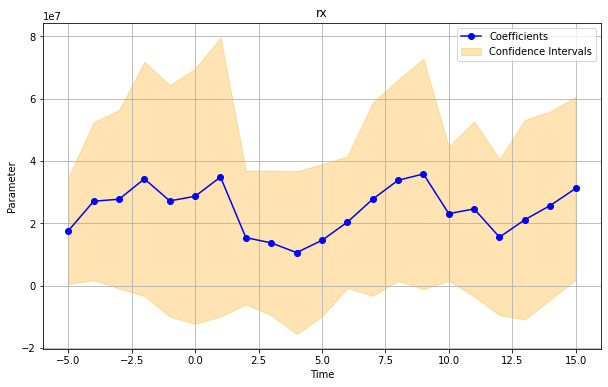

In [14]:
formula="rx_dom ~ year_trend+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
# formula+="+stock_rx_lag"
# gemeric_per
formula+=" + generic_per"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="rx",title="rx")

C:\Users\hakos\AppData\Local\Temp\ipykernel_8956\3797523648.py:8: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5     0.0659     0.0473     1.3944     0.1642     -0.0271      0.1590
elasped_m4     0.0861     0.0482     1.7875     0.0748     -0.0087      0.1808
elasped_m3     0.1390     0.0544     2.5520     0.0112      0.0318      0.2461
elasped_m2     0.0937     0.0642     1.4577     0.1459     -0.0327      0.2201
elasped_m1     0.0539     0.0593     0.9083     0.3644     -0.0629      0.1707
elasped_0      0.0857     0.0731     1.1717     0.2422     -0.0582      0.2295
elasped_1      0.1410     0.0773     1.8243     0.0690     -0.0111      0.2931
elasped_2      0.1058     0.0890     1.1885     0.2355     -0.0694      0.2810
elasped_3      0.0789     0.0813     0.9702     0.3327     -0.0811      0.2388
elasped_4      0.0565     0.0809     0.6988     0.48

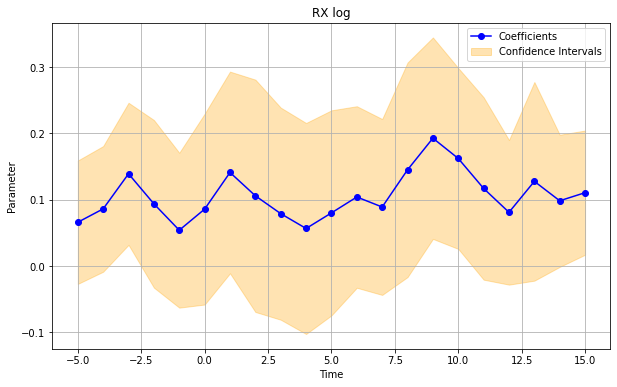

In [16]:
# take log
formula="log_rx_dom ~ year_trend+ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
# formula+="+stock_rx_lag"
# gemeric_per
formula+=" + generic_per"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log",title="RX log")

### OTC

C:\Users\hakos\AppData\Local\Temp\ipykernel_8956\749913949.py:8: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5   4.53e+06  5.691e+06     0.7961     0.4266  -6.665e+06   1.573e+07
elasped_m4  7.723e+05  1.379e+06     0.5602     0.5757   -1.94e+06   3.484e+06
elasped_m3  3.191e+05  1.426e+06     0.2237     0.8231  -2.487e+06   3.125e+06
elasped_m2  2.731e+05  1.702e+06     0.1604     0.8727  -3.076e+06   3.622e+06
elasped_m1 -1.979e+06  9.552e+05    -2.0718     0.0391  -3.858e+06  -9.974e+04
elasped_0  -1.294e+06  5.698e+05    -2.2704     0.0238  -2.414e+06  -1.726e+05
elasped_1  -2.722e+05  2.038e+06    -0.1336     0.8938  -4.281e+06   3.737e+06
elasped_2  -9.347e+05  1.684e+06    -0.5550     0.5793  -4.248e+06   2.379e+06
elasped_3  -5.264e+05  1.274e+06    -0.4133     0.6797  -3.033e+06    1.98e+06
elasped_4  -1.039e+06  2.023e+06    -0.5134     0.60

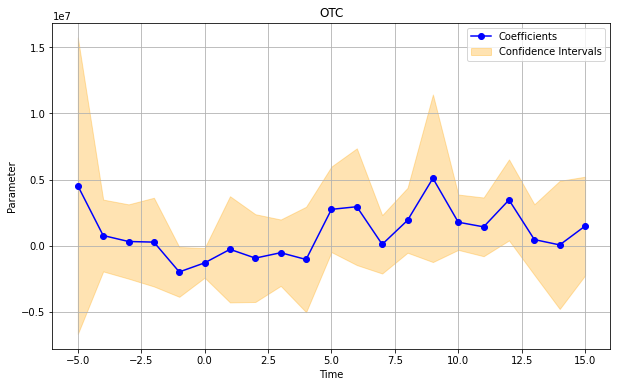

In [10]:

formula="otc_dom ~ year_trend+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
# formula+="+stock_rx_lag"
# gemeric_per
formula+=" + generic_per"
mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="otc",title="OTC")

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_otc_dom   R-squared:                        0.2371
Estimator:                   PanelOLS   R-squared (Between):          -7.549e+21
No. Observations:                 386   R-squared (Within):           -4.988e+23
Date:                Tue, Aug 22 2023   R-squared (Overall):          -7.668e+21
Time:                        12:16:49   Log-likelihood                   -214.81
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.5339
Entities:                          30   P-value                           0.0000
Avg Obs:                       12.867   Distribution:                  F(22,321)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             76.625
                            

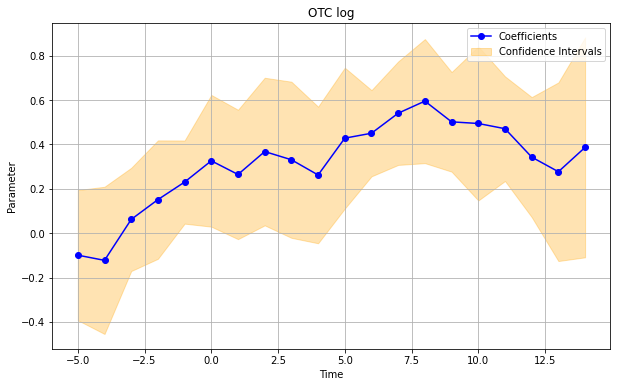

In [15]:
# take log
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# stock lag version
# formula+="+log_stock_otc_lag"

# year trend
# formula+="+year_trend"

# gemeric_per
formula+=" + generic_per"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="otc_log",title="OTC log",start_from=2,period=19)

In [12]:
res_fe.cov

,elasped_m5,elasped_m4,elasped_m3,elasped_m2,elasped_m1,elasped_0,elasped_1,elasped_2,elasped_3,elasped_4,...,elasped_6,elasped_7,elasped_8,elasped_9,elasped_10,elasped_11,elasped_12,elasped_13,elasped_14,elasped_15
elasped_m5,0.011827,0.002220,0.004298,0.005049,0.006802,0.000417,0.001001,-0.000374,0.001662,-0.002048,...,-0.000627,0.003916,0.003873,0.003915,0.003439,0.000625,0.001250,-0.001677,0.001105,-0.001391
elasped_m4,0.002220,0.022168,0.014746,0.008047,0.003983,-0.001837,0.006105,0.010447,0.013500,0.016624,...,0.015202,0.006007,0.005057,0.005421,0.002390,0.013050,0.009214,0.013266,0.017531,0.023897
elasped_m3,0.004298,0.014746,0.028323,0.016808,0.011718,0.002762,0.007636,0.013551,0.011569,0.014192,...,0.009231,0.006876,0.003379,0.007915,0.003546,0.003671,0.005427,0.003976,0.009760,0.018414
elasped_m2,0.005049,0.008047,0.016808,0.013932,0.011751,0.005491,0.008954,0.011030,0.007552,0.008445,...,0.007127,0.005660,0.004325,0.007229,0.003793,0.004548,0.005346,0.002484,0.007239,0.012602
elasped_m1,0.006802,0.003983,0.011718,0.011751,0.018322,0.008415,0.011027,0.009301,0.004636,0.003757,...,0.003274,0.005450,0.006675,0.011659,0.008233,0.004449,0.004036,-0.001082,0.003612,0.005108
elasped_0,0.000417,-0.001837,0.002762,0.005491,0.008415,0.009048,0.009185,0.006017,0.000138,0.001111,...,0.001464,0.003263,0.005394,0.006996,0.005692,0.004161,0.002564,-0.000639,0.002801,0.003757
elasped_1,0.001001,0.006105,0.007636,0.008954,0.011027,0.009185,0.022696,0.016939,0.005164,0.008429,...,0.011722,0.007634,0.010055,0.016018,0.008179,0.016017,0.010396,0.009190,0.017149,0.022066
elasped_2,-0.000374,0.010447,0.013551,0.011030,0.009301,0.006017,0.016939,0.021883,0.015294,0.018618,...,0.018555,0.007461,0.008984,0.015078,0.007606,0.018273,0.013345,0.013237,0.022884,0.030637
elasped_3,0.001662,0.013500,0.011569,0.007552,0.004636,0.000138,0.005164,0.015294,0.028510,0.028450,...,0.017664,0.004929,0.005533,0.007116,0.005548,0.019496,0.013220,0.014455,0.026259,0.031994
elasped_4,-0.002048,0.016624,0.014192,0.008445,0.003757,0.001111,0.008429,0.018618,0.028450,0.031895,...,0.021732,0.006661,0.006118,0.008203,0.005072,0.020963,0.013849,0.017769,0.028742,0.038243


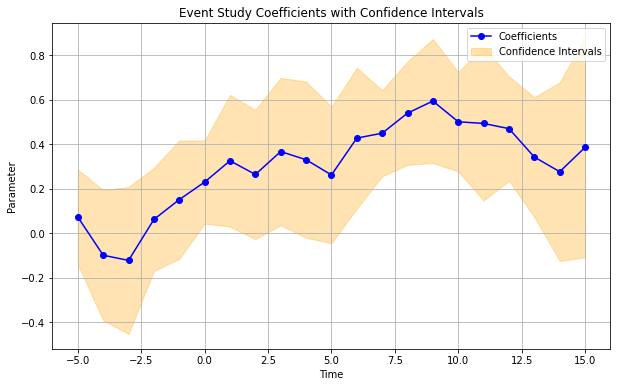

In [13]:
# 天才やん
start_from=1
period=20
summary_table=pd.DataFrame(res_fe.summary.tables[1].data[start_from:start_from+period+1],columns=res_fe.summary.tables[1].data[0])
summary_table["Time"]=np.array(list(range(-5,16)))
# make each column of summary_table numeric
summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot coefficients as points
plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

# Plot confidence intervals as error bars
# plt.errorbar(summary_table['Time'], summary_table["Parameter"],
#              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
#                    summary_table['Upper CI'] - summary_table["Parameter"]],
#              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

plt.xlabel('Time')
plt.ylabel("Parameter")
plt.title('Event Study Coefficients with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()